This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

## Neural style transfer

In  addition  to  DeepDream,  another  major  development  in  deep-learning-driven image modification is *neural style transfer*, introduced by [Leon Gatys et al. in the summer  of  2015](https://arxiv.org/abs/1508.06576). The  neural  style  transfer  algorithm  has  undergone  many  refinements and spawned many variations since its original introduction, and it has made its way into many smartphone photo apps. For simplicity, this section focuses on the formulation described in the original paper.

Neural  style  transfer  consists  of  applying  the  style  of  a  reference  image  to  a  target image while conserving the content of the target image. The Figure below shows an example.

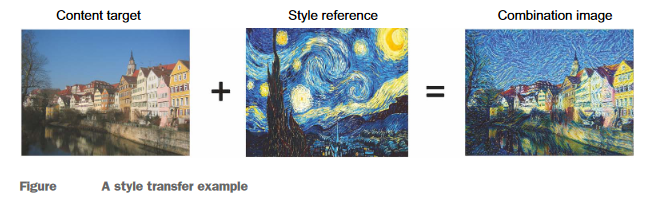

In  this  context,  **style**  essentially  means  textures,  colors,  and  visual  patterns  in  the image, at various spatial scales, and the content is the higher-level macrostructure of the  image.  For instance,  blue-and-yellow  circular  brushstrokes  are  considered  to  be the style in the Figure above (using **Starry Night** by Vincent Van Gogh), and the buildings in the Tübingen photograph are considered to be the content.

The idea of style transfer, which is tightly related to that of texture generation, has had  a  long  history  in  the  image-processing  community  prior  to  the  development  of neural style transfer in 2015. But as it turns out, the deep-learning-based implementations of style transfer offer results unparalleled by what had been previously achieved with classical computer vision techniques, and they triggered an amazing renaissance in creative applications of computer vision.

The key notion behind implementing style transfer is the same idea that's central to all deep learning algorithms: you define a loss function to specify what you want to achieve, and you minimize this loss. We know what we want to achieve: conserving the content  of  the  original  image  while  adopting  the  style  of  the  reference  image.  If  we were able to mathematically define content and style, then an appropriate loss function to minimize would be the following:

```
loss = (distance(style(reference_image) - style(combination_image)) +
        distance(content(original_image) - content(combination_image)))
```



Here,  **distance**  is  a  norm  function  such  as  the  L2  norm,  **content**  is  a  function  that takes an image and computes a representation of its content, and **style** is a function that  takes  an  image  and  computes  a  representation  of  its  style.  Minimizing  this  loss causes `style(combination_image)`  to  be  close  to  `style(reference_image)`,  and `content(combination_image)` is  close  to  `content(original_image)`,  thus  achieving style transfer as we defined it.

A fundamental observation made by Gatys et al. was that deep convolutional neural  networks  offer  a  way  to  mathematically  define  the  **style**  and  **content**  functions. Let's see how.

### The content loss

As you already know, activations from earlier layers in a network contain **local** information  about  the  image,  whereas  activations  from  higher  layers  contain  increasingly global, abstract information. Formulated in a different way, the activations of the dif-
ferent layers of a convnet provide a decomposition of the contents of an image over different  spatial  scales.  Therefore, you'd  expect  the  content  of  an  image,  which  is more global and abstract, to be captured by the representations of the upper layers in a convnet.

A good candidate for content loss is thus the L2 norm between the activations of an upper layer in a pretrained convnet, computed over the target image, and the activations of the same layer computed over the generated image. This guarantees that, as seen from the upper layer, the generated image will look similar to the original target image. Assuming that what the upper layers of a convnet see is really the content of
their input images, this works as a way to preserve image content.

### The style loss

The content loss only uses a single upper layer, but the style loss as defined by Gatys et al. uses multiple layers of a convnet: you try to capture the appearance of the style-reference  image  at  all  spatial  scales  extracted  by  the  convnet,  not  just a  single  scale.
For the style loss, Gatys et al. use the **Gram matrix** of a layer's activations: the inner product of the feature maps of a given layer. This inner product can be understood as representing a map of the correlations between the layer's features. These feature correlations  capture  the  statistics  of  the  patterns  of  a  particular  spatial  scale, which empirically correspond to the appearance of the textures found at this scale.

Hence, the style loss aims to preserve similar internal correlations within the activations of different layers, across the style-reference image and the generated image. In turn,  this  guarantees  that  the  textures  found  at  different  spatial  scales  look  similar across the style-reference image and the generated image.

In short, you can use a pretrained convnet to define a loss that will do the following:

* Preserve content by maintaining similar high-level layer activations between the original  image  and  the  generated  image.  The  convnet  should  "see"  both  the original image and the generated image as containing the same things.
* Preserve style by maintaining similar correlations within activations for both low-level layers and high-level layers. Feature correlations capture textures: the generated  image  and  the  style-reference  image  should  share  the  same  textures  at different spatial scales.

Now  let's  look  at  a  Keras  implementation  of  the  original  2015  neural  style  transfer algorithm. As you'll see, it shares many similarities with the DeepDream implementation we developed in the previous section.

### Neural style transfer in Keras

Neural  style  transfer  can  be  implemented  using  any  pretrained  convnet.  Here,  we'll use the VGG19 network used by Gatys et al. VGG19 is a variant of the VGG16 network introduced in chapter 5, with three more convolutional layers.

Here's the general process:

*   Set up a network that computes VGG19 layer activations for the style-reference image, the base image, and the generated image at the same time.
*   Use the layer activations computed over these three images to define the loss function  described  earlier,  which  we'll  minimize  in  order  to  achieve  style transfer.
*   Set up a gradient-descent process to minimize this loss function.

Let's start by defining the paths to the style-reference image and the base image. To make  sure  that  the  processed  images  are  a  similar  size  (widely  different  sizes  make style transfer more difficult), we'll later resize them all to a shared height of 400 px.



**Getting the style and content images**

In [1]:
from tensorflow import keras

base_image_path = keras.utils.get_file(                                         # Path to the image we want to transform.
    "sf.jpg", origin="https://img-datasets.s3.amazonaws.com/sf.jpg")
style_reference_image_path = keras.utils.get_file(                              # Path to the style image.
    "starry_night.jpg", origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg")

original_width, original_height = keras.utils.load_img(base_image_path).size    # Dimensions of the generated picture.
img_height = 400
img_width = round(original_width * img_height / original_height)

943128/943128 [==============================] - 0s 0us/step


Our content and style images are shown below.

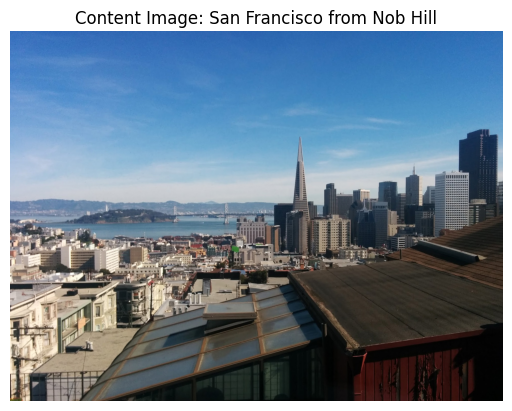

In [6]:
import matplotlib.pyplot as plt

plt.axis("off")
plt.title('Content Image: San Francisco from Nob Hill')
plt.imshow(keras.utils.load_img(base_image_path))

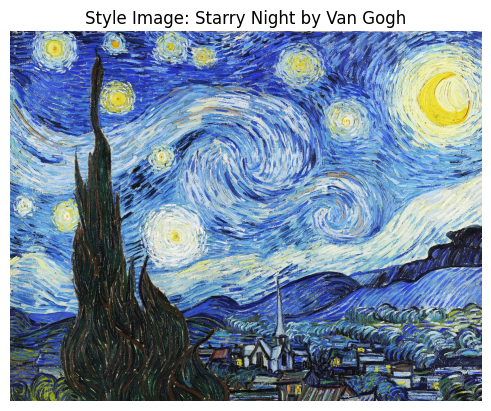

In [5]:
plt.axis("off")
plt.title('Style Image: Starry Night by Van Gogh')
plt.imshow(keras.utils.load_img(style_reference_image_path))

**Auxiliary functions**

We also need some auxiliary functions for loading, preprocessing, and postprocessing the images that go in and out of the VGG19 convnet.

In [7]:
import numpy as np

def preprocess_image(image_path):                                               # Util function to open, resize, and format pictures into appropriate arrays.
    img = keras.utils.load_img(
        image_path, target_size=(img_height, img_width))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_image(img):                                                       # Util function to convert a NumPy array into a valid image.
    img = img.reshape((img_height, img_width, 3))
    img[:, :, 0] += 103.939                                                     # Zero-centering by removing the mean pixel value from ImageNet.
    img[:, :, 1] += 116.779                                                     # This reverses a transformation done by vgg19.preprocess_input.
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]                                                       # Converts images from ’BGR’ to ’RGB’. This is also part of the reversal of
                                                                                # vgg19.preprocess_input.
    img = np.clip(img, 0, 255).astype("uint8")
    return img

Let's set up the VGG19 network. Like in the DeepDream example, we'll use the pretrained convnet to create a feature exactor model that returns the activations of intermediate layers—all layers in the model this time.

**Using a pretrained VGG19 model to create a feature extractor**

In [8]:
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)   # Build a VGG19 model loaded with pretrained ImageNet weights.

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)      # Model that returns the activation values for every target layer (as a dict).

80134624/80134624 [==============================] - 0s 0us/step


Let's define the content loss, which will make sure the top layer of the VGG19 convnet has a similar view of the style image and the combination image.

**Content loss**

In [9]:
def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img))

Next is the style loss. It uses an auxiliary function to compute the Gram matrix of an input matrix: a map of the correlations found in the original feature matrix.

**Style loss**

In [10]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style_img, combination_img):
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

To these two loss components, you add a third: the **total variation loss**, which operates on the pixels of the generated combination image. It encourages spatial continuity in the generated image, thus avoiding overly pixelated results. You can interpret it as a regularization loss.

**Total variation loss**

In [11]:
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :]
    )
    b = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

The loss that you minimize is a **weighted average** of these three losses. To compute the content loss, you use only one upper layer—the `block5_conv2` layer—whereas for the style loss, you use a list of layers that spans both low-level and high-level layers. You add the total variation loss at the end.

Depending  on  the  style-reference  image  and  content  image  you're  using,  you'll likely  want  to  tune  the `content_weight` coefficient  (the  contribution  of  the  content loss to the total loss). A higher `content_weight` means the target content will be more recognizable in the generated image.

**Defining the final loss that you'll minimize**

In [12]:
style_layer_names = [                                                           # List of layers to use for the style loss.
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layer_name = "block5_conv2"                                             # The layer to use for the content loss.
total_variation_weight = 1e-6                                                   # Contribution weight of the total variation loss.
style_weight = 1e-6                                                             # Contribution weight of the style loss.
content_weight = 2.5e-8                                                         # Contribution weight of the content loss.

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())                                                   # Initialize the loss to 0.
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(                                # Add the content loss.
        base_image_features, combination_features
    )
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(
          style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value      # Add the style loss.

    loss += total_variation_weight * total_variation_loss(combination_image)    # Add the total variation loss.
    return loss

Finally, let's set up the gradient-descent process. In the original Gatys et al. paper, optimization is performed using the L-BFGS algorithm, but that's not available in Tensor-Flow, so we'll just do mini-batch gradient descent with the SGD optimizer instead. We'll leverage an optimizer feature you haven't seen before: a **learning-rate schedule**. We'll use it to gradually decrease the learning rate from a very high value (100) to a much smaller final value (about 20). That way, we'll make fast progress in the early stages of training and then proceed more cautiously as we get closer to the loss minimum.

**Setting up the gradient-descent process**

In [ ]:
import tensorflow as tf

@tf.function                                                                    # We make the training step fast by compiling it as a tf.function.
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"combination_image_at_iteration_{i}.png"
        keras.utils.save_img(fname, img)

### Wrapping up